### BRIEF ANALYSIS OF PRECIPITATION VARIABILITY

this code tries to analysise the distribution for the climathology of precipitation and how 'extreme' precipitation situations relate to the other variables considered in the ML model (Temperature and Evapotranspiration).

In [1]:
from base_f import feature_sel, loyo_cv_lc, create_it_matrix, monthly_climatology, daily_climatology,root_mean_squared_error
from climatology_ensemble import  daily_climatology_p_ensemble
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns
import joblib

In [21]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
## Feature selection
daily_input = pd.read_csv(path+'HEDravograd_Drava_1952_2019.txt', index_col=0, parse_dates=True)

t_unit=30

In [22]:
runoff = daily_input[['Q']]
temp = daily_input[[c for c in daily_input.columns if c[0] == 'T']]
prec = daily_input[[c for c in daily_input.columns if c[0] == 'P']]
evap = daily_input[[c for c in daily_input.columns if c[0] == 'E']]

In [23]:
# Compute the t_unit days average runoff
runoff_t_unit = runoff.rolling(t_unit, min_periods=t_unit).mean()
runoff_q75=runoff_t_unit.groupby(by=runoff_t_unit.index.day_of_year).quantile(q=0.75)
runoff_q25=runoff_t_unit.groupby(by=runoff_t_unit.index.day_of_year).quantile(q=0.25)

In [24]:
runoff['doty']=runoff.index.day_of_year
runoff_t_unit['doty']=runoff.index.day_of_year
runoff['moty']=runoff.index.month_name()
runoff_t_unit['moty']=runoff.index.month_name()

C:\Users\MMAZZO~1\AppData\Local\Temp/ipykernel_6704/2252962907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runoff['doty']=runoff.index.day_of_year
C:\Users\MMAZZO~1\AppData\Local\Temp/ipykernel_6704/2252962907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runoff['moty']=runoff.index.month_name()


<AxesSubplot:xlabel='doty', ylabel='Q'>

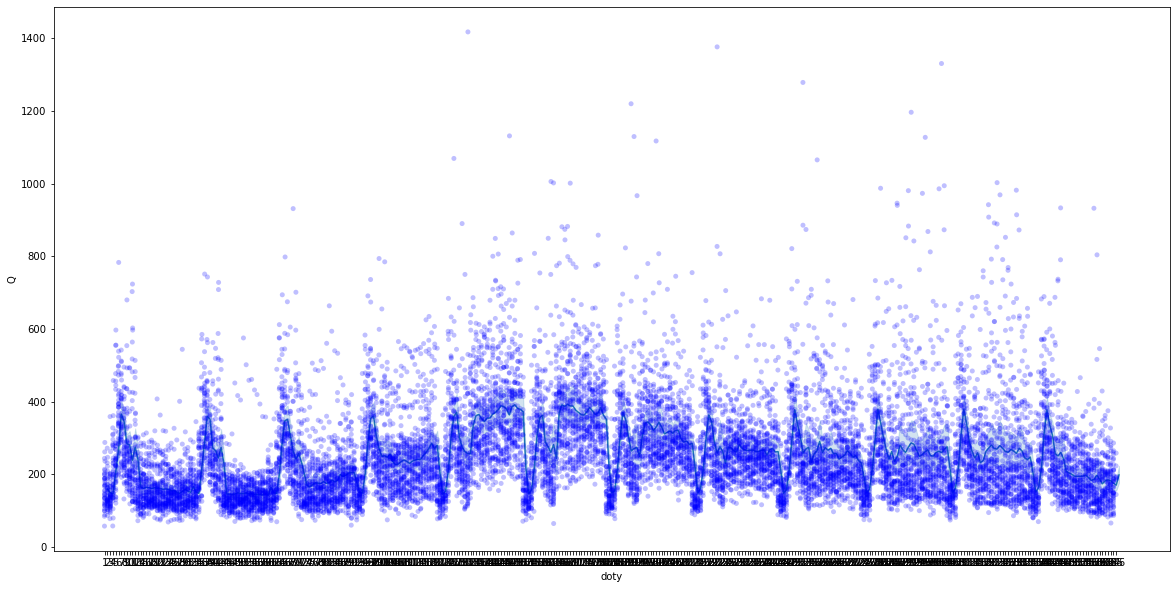

In [25]:

plt.figure(figsize=(20,10))
g=sns.stripplot(x="doty", y="Q",
              data=runoff, dodge=True, alpha=.25,color='blue')
#g.set_xticklabels(runoff.index.day_of_year.unique().month_name())
sns.lineplot(x="doty", y="Q",
              data=runoff, palette=['red'])
#g.tight_layout()

<AxesSubplot:xlabel='doty', ylabel='Q'>

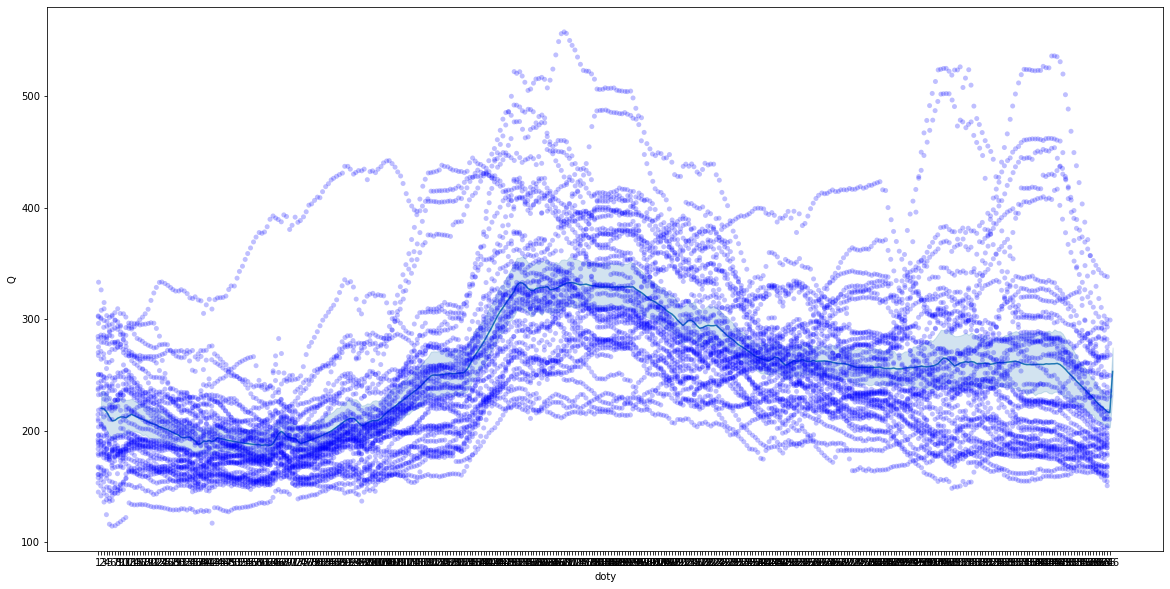

In [26]:
plt.figure(figsize=(20,10))
sns.stripplot(x="doty", y="Q",
              data=runoff_t_unit, dodge=True, alpha=.25,color='blue')
#g.set_xticklabels(prec_plot.index.month_name().unique())
sns.lineplot(x="doty", y="Q",
              data=runoff_t_unit, palette=['red'])
#g.tight_layout()

<AxesSubplot:xlabel='doty', ylabel='Q'>

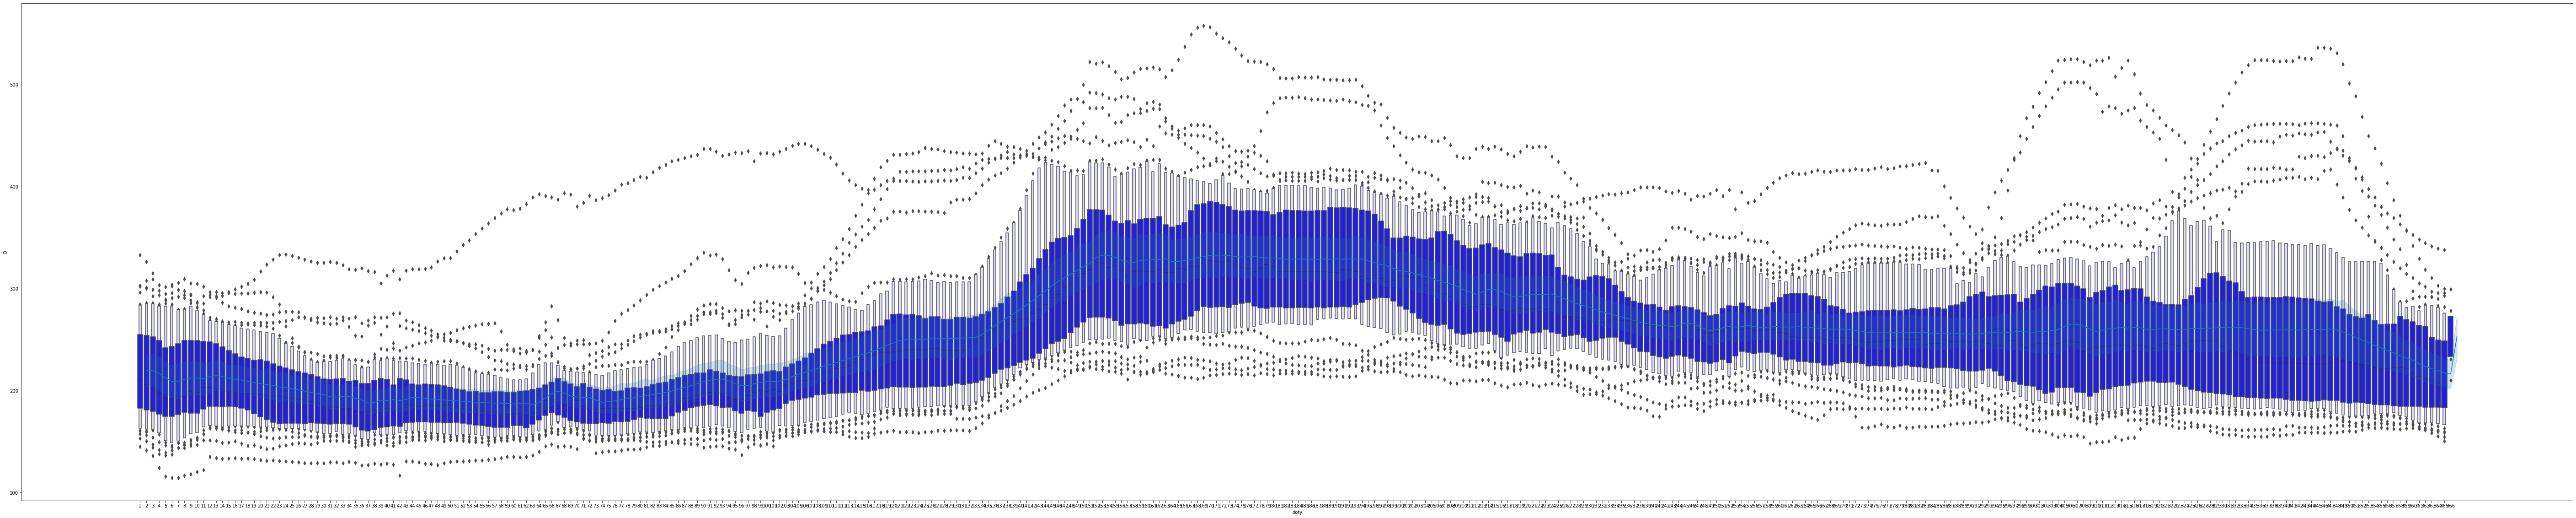

In [27]:
plt.figure(figsize=(100,20))

sns.boxenplot(x="doty", y="Q",
              data=runoff_t_unit,color="b",scale="linear",)
sns.lineplot(x="doty", y="Q",
              data=runoff_t_unit, palette=['red'])

[Text(15, 0, 'January'),
 Text(45, 0, 'February'),
 Text(75, 0, 'March'),
 Text(105, 0, 'April'),
 Text(135, 0, 'May'),
 Text(165, 0, 'June'),
 Text(195, 0, 'July'),
 Text(225, 0, 'August'),
 Text(255, 0, 'September'),
 Text(285, 0, 'October'),
 Text(315, 0, 'November'),
 Text(345, 0, 'December')]

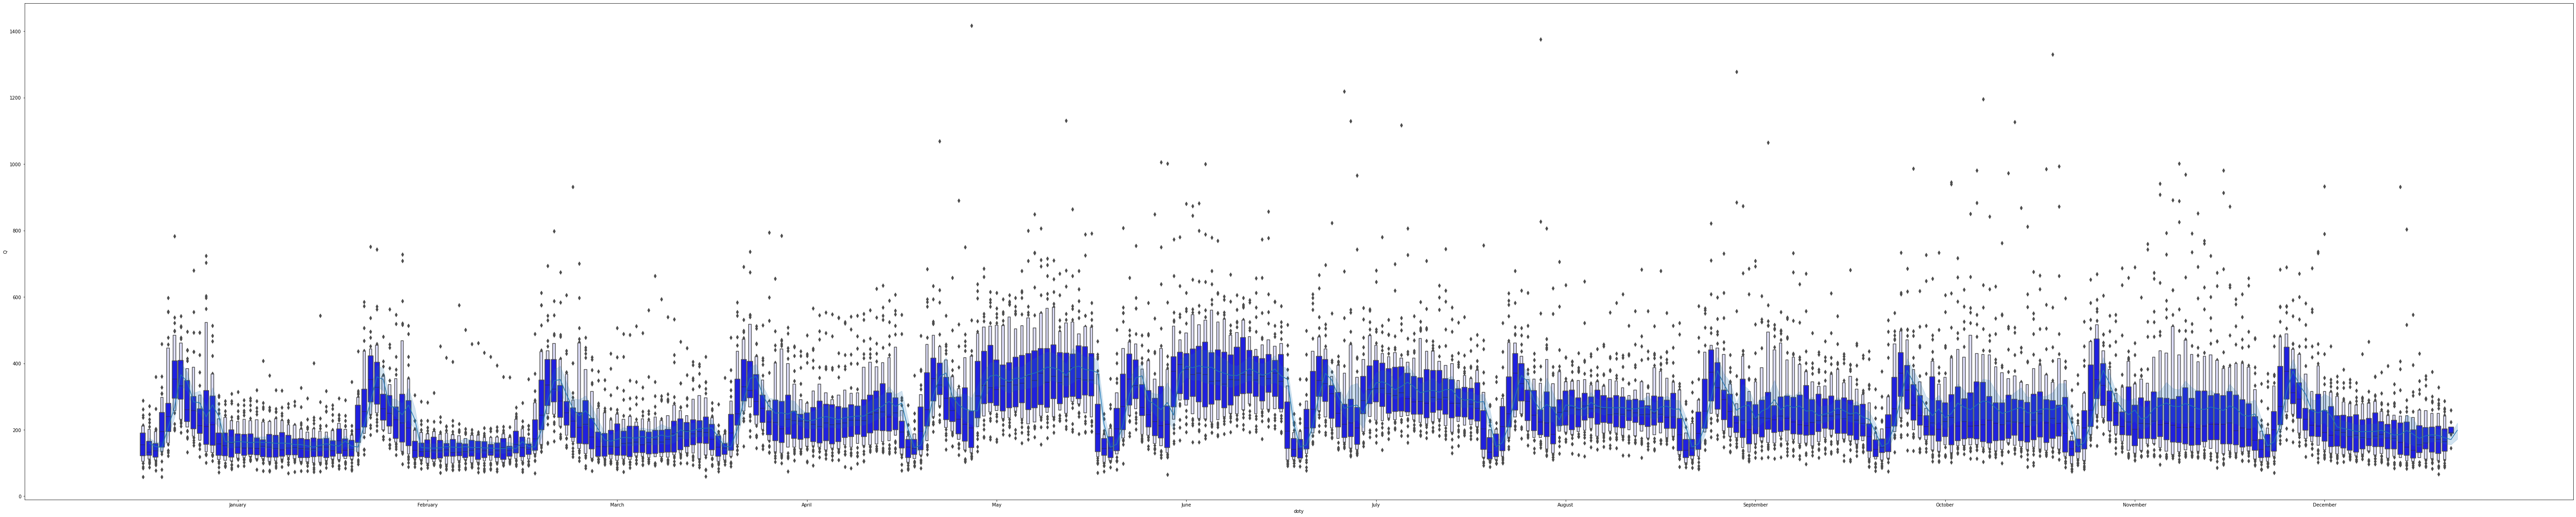

In [28]:
plt.figure(figsize=(100,20))

g=sns.boxenplot(x="doty", y="Q",
              data=runoff,color="b",scale="linear",)
g=sns.lineplot(x="doty", y="Q",
              data=runoff, palette=['red'])
g.set_xticks((range(15,365,30)))
g.set_xticklabels(runoff.index.month_name().unique())

In [25]:
runoff_t_unit

,Q,doty
1979-01-01,NaN,1
1979-01-02,NaN,2
1979-01-03,NaN,3
1979-01-04,NaN,4
1979-01-05,NaN,5
...,...,...
2018-12-27,160.958733,361
2018-12-28,158.742333,362
2018-12-29,151.701800,363
2018-12-30,149.579000,364


In [3]:
# Compute the t_unit days average temperature
if not temp.empty:
    temp_t_unit = temp.rolling(t_unit, min_periods=t_unit).mean()


# Compute the t_unit days sum evapotranspiration
if not evap.empty:
    evap_t_unit = evap.rolling(t_unit, min_periods=t_unit).sum()


# Compute the t_unit days sum precipitation
if not prec.empty:
    prec_t_unit = prec.rolling(t_unit, min_periods=t_unit).sum()

daily_t_unit = pd.concat([runoff_t_unit, temp_t_unit, evap_t_unit], axis=1)
daily = daily_t_unit.groupby(by=daily_t_unit.index.day_of_year).mean()


prec_mean=prec_t_unit.groupby(by=prec_t_unit.index.day_of_year).mean()
prec_q75=prec_t_unit.groupby(by=prec_t_unit.index.day_of_year).quantile(q=0.75)
prec_q75=prec_q75.add_suffix('_Q75')
prec_q25=prec_t_unit.groupby(by=prec_t_unit.index.day_of_year).quantile(q=0.25)
prec_q25=prec_q25.add_suffix('_Q25')
#pdb.set_trace()
daily_tot   = pd.concat([daily,prec_mean,prec_q75,prec_q25], axis=1)
#pdb.set_trace()

In [4]:
prec_plot=prec_t_unit.copy(deep=True)
prec_plot['avg_prec']=prec_t_unit.mean(axis=1)
prec_plot['doty']=prec_t_unit.index.day_of_year
prec_plot['moty']=prec_t_unit.index.month_name()
prec_plot['y']=prec_t_unit.index.year


<AxesSubplot:>

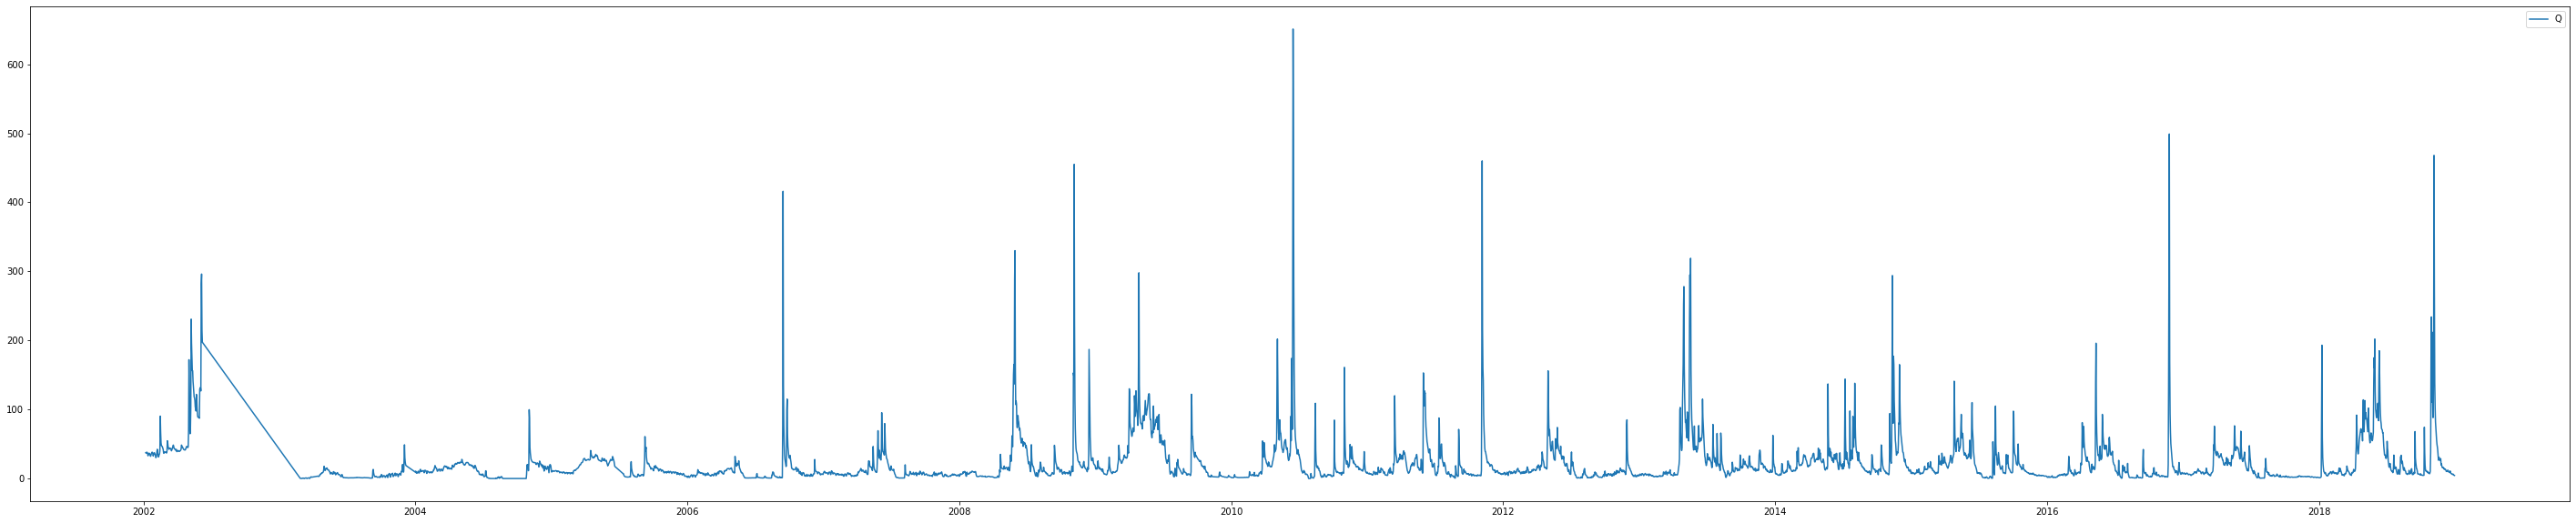

In [5]:
plt.figure(figsize=(50,10))
sns.lineplot(data=runoff)

<AxesSubplot:xlabel='doty', ylabel='avg_prec'>

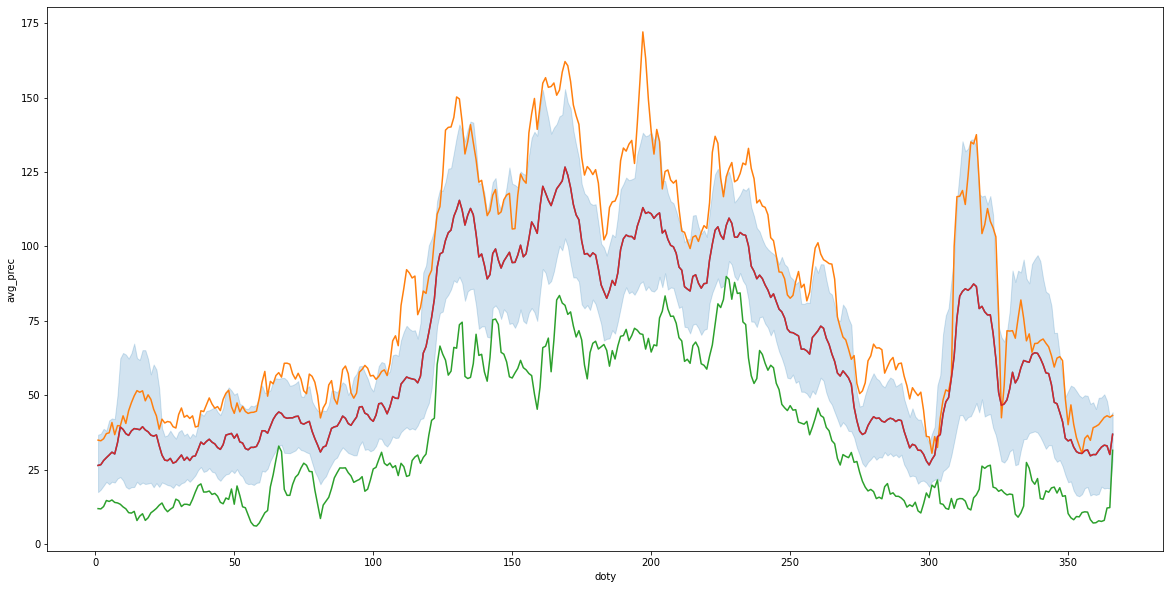

In [6]:
plt.figure(figsize=(20,10))
sns.lineplot(y='avg_prec',x='doty',data=prec_plot,estimator=np.mean)
sns.lineplot(data=prec_q75.mean(axis=1),palette=['orange'])
sns.lineplot(data=prec_q25.mean(axis=1),palette=['green'])
sns.lineplot(data=prec_mean.mean(axis=1),palette=['red'])

In [38]:

temp_q75=pd.DataFrame(data=None, columns=temp_t_unit.columns)
evap_q75=pd.DataFrame(data=None, columns=evap_t_unit.columns)

temp_q25=pd.DataFrame(data=None, columns=temp_t_unit.columns)
evap_q25=pd.DataFrame(data=None, columns=evap_t_unit.columns)

#get the range as 2/3 of the mean difference between the quantile and the mean precipitation over the year.
radius=0.9



range75= radius*(prec_q75.mean().mean()-prec_t_unit).mean().mean()
range25= radius*(-prec_q25.mean().mean()+prec_t_unit).mean().mean()

for i in range(1,367):
    
    #get dates where the dayofyear is ==1 for the 3 variables
    day_i=(prec_t_unit.index.day_of_year==i)
    prec_t_unit_i=prec_t_unit[day_i]
    temp_t_unit_i=temp_t_unit[day_i]
    evap_t_unit_i=evap_t_unit[day_i]    
    
    #compute the mean and interesting quantiles for the precipitation
    prec_t_unit_i_mean=prec_t_unit_i.drop(columns=prec_t_unit.columns[-4:]).mean(axis=1)
    prec_q75_i=prec_q75[prec_q75.index==i].mean(axis=1)
    prec_q25_i=prec_q25[prec_q25.index==i].mean(axis=1)
    
    #select the situations where the precipitation is similar (closer than a range) to the quantile
    situations75=(np.abs(np.array(prec_t_unit_i_mean)-np.array(prec_q75_i))<range75)
    situations25=(np.abs(np.array(prec_t_unit_i_mean)-np.array(prec_q25_i))<range25)
    
    #average the variables values happened int the selected situations and append it
    s=temp_t_unit_i[situations75].mean()
    s.name=i
    temp_q75=temp_q75.append(s)
    
    s=evap_t_unit_i[situations75].mean()
    s.name=i
    evap_q75=evap_q75.append(s)

    s=temp_t_unit_i[situations25].mean()
    s.name=i
    temp_q25=temp_q25.append(s)
    
    s=evap_t_unit_i[situations25].mean()
    s.name=i
    evap_q25=evap_q25.append(s)

temp_q75=temp_q75.add_suffix('_Q75')
evap_q75=evap_q75.add_suffix('_Q75')

temp_q25=temp_q25.add_suffix('_Q25')
evap_q25=evap_q25.add_suffix('_Q25')

<AxesSubplot:xlabel='doty', ylabel='avg_prec'>

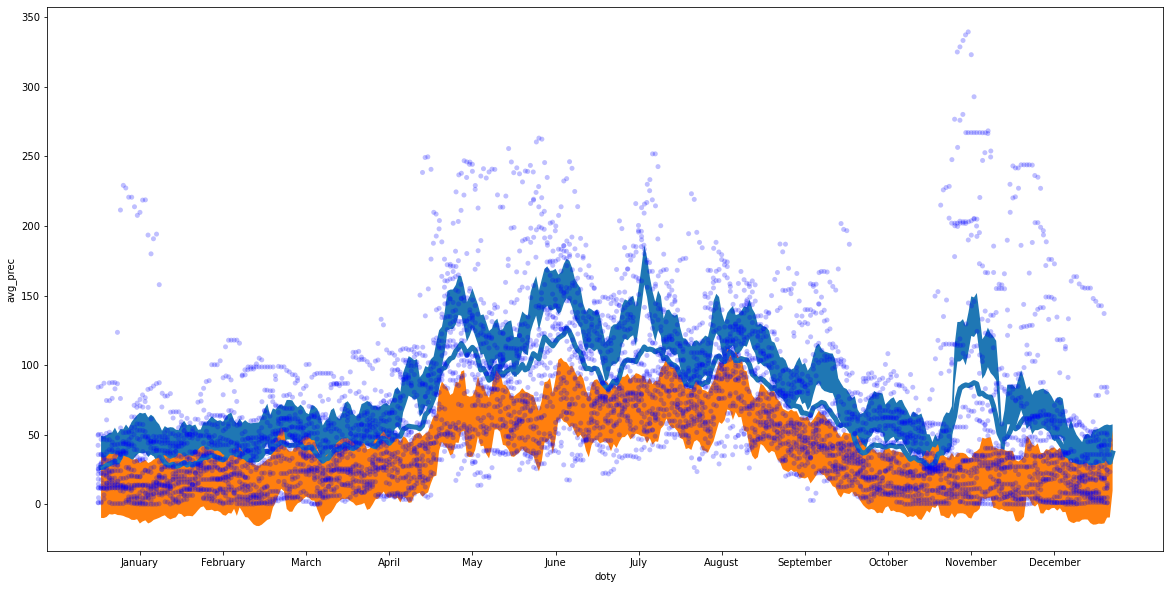

In [31]:
plt.figure(figsize=(20,10))
g=sns.stripplot(y='avg_prec',x='doty',data=prec_plot,dodge=True,alpha=0.25,jitter=True,color='blue')#,hue='y')
g.set_xticks((range(15,360,30)))
g.set_xticklabels(prec_plot.index.month_name().unique())

g.fill_between(x=range(1,367), y1=(prec_q75.mean(axis=1)+range75),y2=(prec_q75.mean(axis=1)-range75))
#sns.lineplot(data=data_sel_75.transpose())#,palette=['black'])
g.fill_between(x=range(1,367), y1=(prec_q25.mean(axis=1)+range25),y2=(prec_q25.mean(axis=1)-range25))

sns.lineplot(data=prec_mean.mean(axis=1),palette=['blue'],linewidth=5)

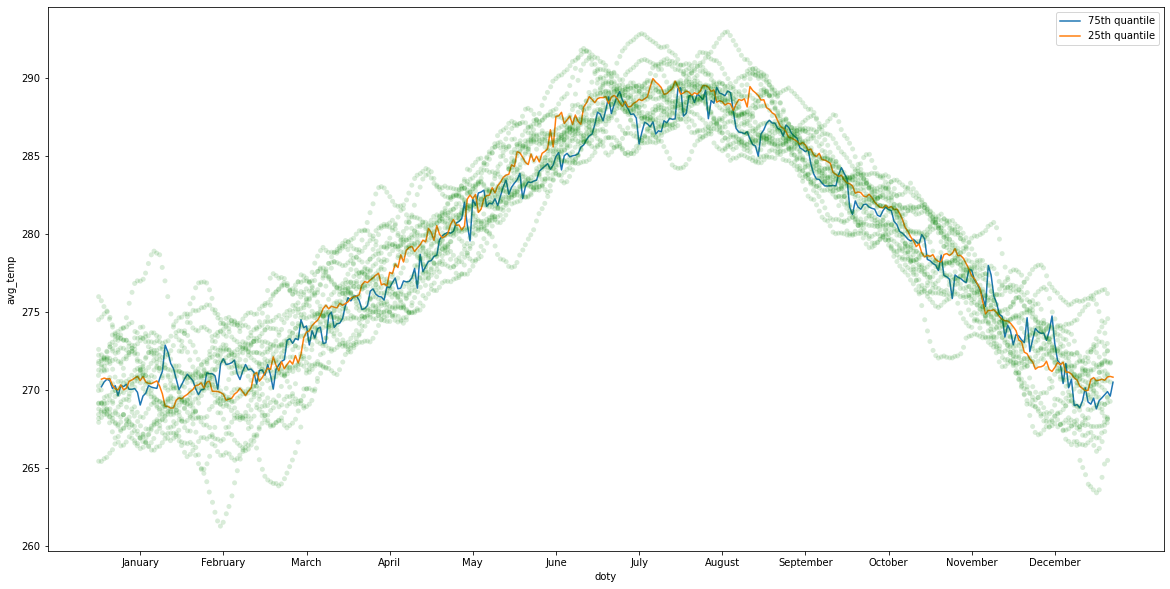

In [32]:
temp_plot=temp_t_unit.copy(deep=True)
temp_plot['avg_temp']=temp_t_unit.mean(axis=1)
temp_plot['doty']=temp_t_unit.index.day_of_year

temp_q75_p=pd.DataFrame(data=None)
temp_q75_p['avg_temp']=temp_q75.mean(axis=1)
temp_q75_p['doty']=temp_q75.index

temp_q25_p=pd.DataFrame(data=None)
temp_q25_p['avg_temp']=temp_q25.mean(axis=1)
temp_q25_p['doty']=temp_q25.index


plt.figure(figsize=(20,10))

g=sns.stripplot(y='avg_temp',x='doty',data=temp_plot,dodge=True,alpha=0.15,jitter=True,color='green')#,hue='y')

g.set_xticks((range(15,360,30)))
g.set_xticklabels(prec_plot.index.month_name().unique())

sns.lineplot(y='avg_temp',x='doty',sizes=(3),data=temp_q75_p,label='75th quantile')
sns.lineplot(y='avg_temp',x='doty',sizes=(3),data=temp_q25_p,label='25th quantile')

plt.legend()


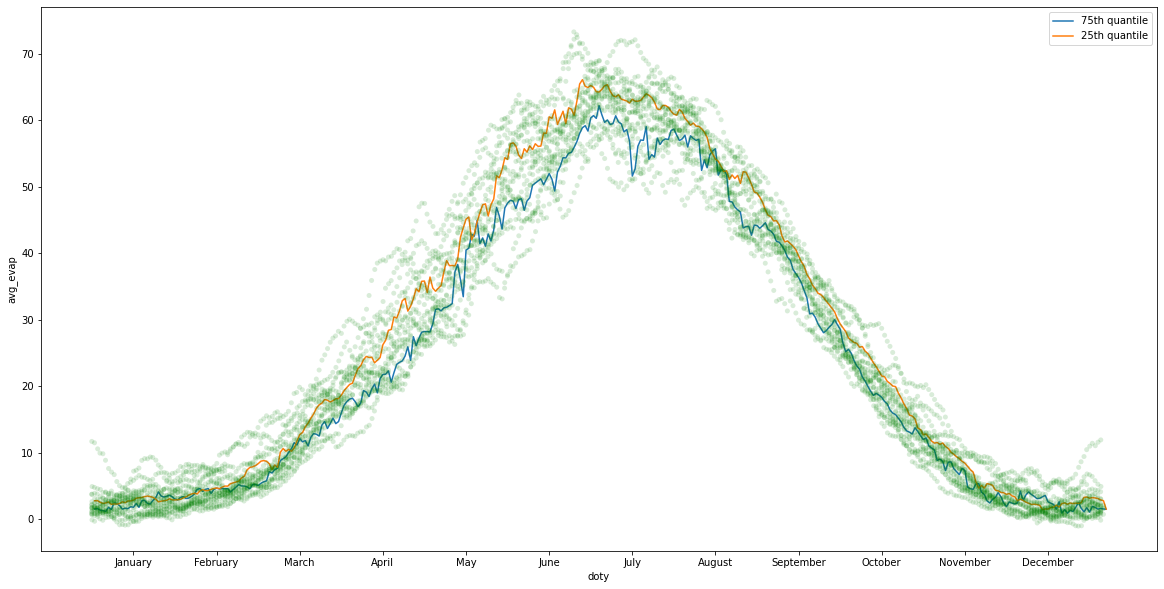

In [33]:
evap_plot=evap_t_unit.copy(deep=True)
evap_plot['avg_evap']=evap_t_unit.mean(axis=1)
evap_plot['doty']=evap_t_unit.index.day_of_year

evap_q75_p=pd.DataFrame(data=None)
evap_q75_p['avg_evap']=evap_q75.mean(axis=1)
evap_q75_p['doty']=evap_q75.index

evap_q25_p=pd.DataFrame(data=None)
evap_q25_p['avg_evap']=evap_q25.mean(axis=1)
evap_q25_p['doty']=evap_q25.index


plt.figure(figsize=(20,10))
g=sns.stripplot(y='avg_evap',x='doty',data=evap_plot,dodge=True,alpha=0.15,jitter=True,color='green')#,hue='y')

g.set_xticks((range(15,360,30)))
g.set_xticklabels(prec_plot.index.month_name().unique())

sns.lineplot(y='avg_evap',x='doty',data=evap_q75_p,label='75th quantile')
sns.lineplot(y='avg_evap',x='doty',data=evap_q25_p,label='25th quantile')

plt.legend()
